### MNIST Model and Misclassified Images

In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import alibi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  False


In [2]:
print(alibi.__version__)

0.6.2


In [3]:
x_train = np.load('quickdraw_x_train.npy')
y_train = np.load('quickdraw_y_train.npy')
x_test = np.load('quickdraw_x_test.npy')
y_test = np.load('quickdraw_y_test.npy')

### Evaluate MC-Model on Test Set

In [4]:
cnn=load_model('cnn_quickdraw_5_classes.h5')

### CF-Proto

In [5]:
from alibi.explainers import CounterfactualProto, CEM, Counterfactual

#### Defining and training the Autoencoder

In [6]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

In [7]:
#ae, enc, dec = ae_model()
#ae.fit(x_train, x_train, batch_size=128, epochs=4, verbose=1)
#ae.save('quickdraw_5_ae.h5', save_format='h5')
#enc.save('quickdraw_5_enc.h5', save_format='h5')

In [8]:
ae = tf.keras.models.load_model('quickdraw_5_ae.h5')
enc = tf.keras.models.load_model('quickdraw_5_enc.h5')

In [9]:
misclassification_indices_test_set = np.load('quickdraw_misclassification_indices_test_set.npy')

In [10]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

In [11]:
# initialize explainer, fit and generate counterfactuals

cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)  

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (-0.5, 0.5),
              'gamma': 100.0,
              'theta': 100.0,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': False,
              'learning_rate_init': 0.01,
              'max_iterations': 1000,
              'c_init': 1.0,
              'c_steps': 2,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'shape': (1, 28, 28, 1),
              'is_model': True,
              'is_ae': True,
              'is_enc': True,
              'enc_or_kdtree': True,
              'is_cat': False,
              'trustscore_kwargs': None,
              'd_type': 'abdm',
              'w': None,
              'd

In [12]:
quickdraw_vlk_cf = []

for instance, target in zip(misclassification_indices_test_set, np.argmax((y_test[misclassification_indices_test_set[:]]), axis=1)):

    X = x_test[instance].reshape((1,) + x_test[0].shape)
    
    explanation_proto = cf.explain(X, k=5, k_type='mean', target_class=[target])
    
    quickdraw_vlk_cf.append(explanation_proto.cf['X'])
    
quickdraw_vlk_cf = np.array(quickdraw_vlk_cf).reshape(30,28,28,1)
    

### CEM- CF

In [13]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(),x_train.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our images, the background (-0.5) is the least informative,
                  # so positive/negative perturbations imply adding/removing features

In [14]:
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)


In [15]:
quickdraw_cem_cf = []

for instance in misclassification_indices_test_set:

    X = x_test[instance].reshape((1,) + x_test[0].shape)
    
    explanation_cem = cem.explain(X)
    
    quickdraw_cem_cf.append(explanation_cem.PN)
    
quickdraw_cem_cf = np.array(quickdraw_cem_cf).reshape(30,28,28,1)

### Min - Edit CF

In [16]:
shape = (1,) + x_train.shape[1:]
target_proba = 0.51
tol = 0.01 
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

In [17]:
quickdraw_min_edit_cf = []

for instance, target in zip(misclassification_indices_test_set, np.argmax((y_test[misclassification_indices_test_set[:]]), axis=1)):

    
    cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)
    
    
    X = x_test[instance].reshape((1,) + x_test[0].shape)
    
    
    explanation_min_edit = cf.explain(X)
    
    quickdraw_min_edit_cf.append(explanation_min_edit.cf['X'])
    
quickdraw_min_edit_cf = np.array(quickdraw_min_edit_cf).reshape(30,28,28,1)
    

### Saving the Generated Explanations

In [29]:
#np.save('quickdraw_min_edit_cf.npy', quickdraw_min_edit_cf)
#np.save('quickdraw_cem_cf.npy', quickdraw_cem_cf)
#np.save('quickdraw_vlk_cf.npy', quickdraw_vlk_cf)

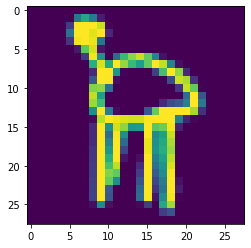

In [107]:
plt.imshow(quickdraw_min_edit_cf[4])

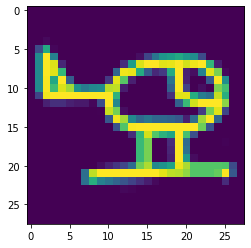

In [102]:
plt.imshow(quickdraw_cem_cf[13])

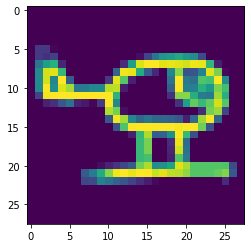

In [103]:
plt.imshow(quickdraw_vlk_cf[13])

In [109]:
user_0 = np.load('../../../../../../eoind/cfe_quickdraw_0.npy')
user_1 = np.load('../../../../../../eoind/cfe_quickdraw_1.npy')
user_2 = np.load('../../../../../../eoind/cfe_quickdraw_2.npy')
user_3 = np.load('../../../../../../eoind/cfe_quickdraw_3.npy')
user_4 = np.load('../../../../../../eoind/cfe_quickdraw_4.npy')

In [157]:
user_counterfactual_dataset = []

for user in [user_0, user_1, user_2, user_3, user_4]:
    
    user_counterfactual_dataset.append(user)
    
user_counterfactual_dataset = np.array(user_counterfactual_dataset)

In [158]:
user_counterfactual_dataset.shape

(5, 30, 28, 28, 1)

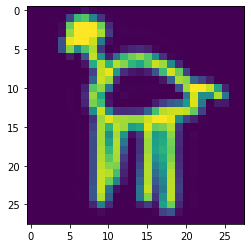

In [113]:
plt.imshow(user_4[4])

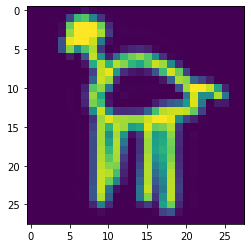

In [159]:
plt.imshow(user_counterfactual_dataset[4][4])

In [160]:
np.save('user_explanations_quickdraw.npy', user_counterfactual_dataset)

In [100]:
cnn.predict(x_test[2].reshape(1,28,28,1))

array([[8.6708717e-08, 1.8923038e-07, 5.6701204e-08, 9.9999833e-01,
        1.2999668e-06]], dtype=float32)

### Visualizing Human Explanations

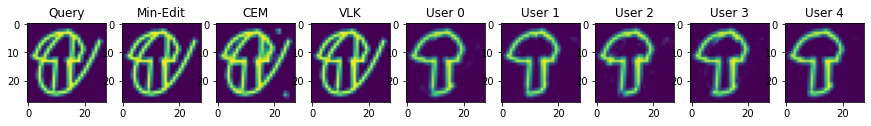

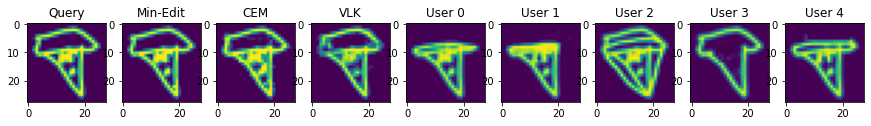

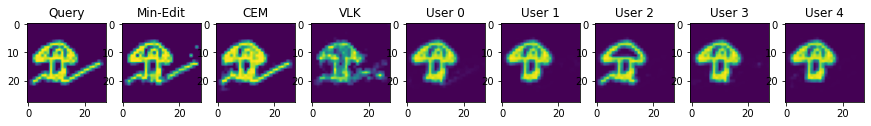

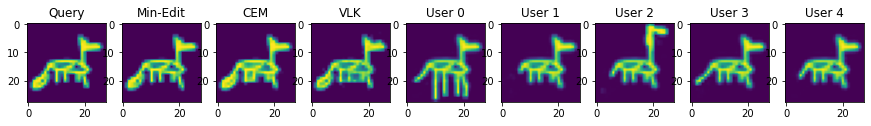

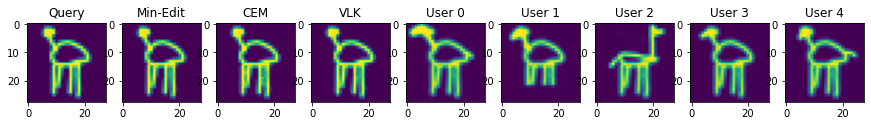

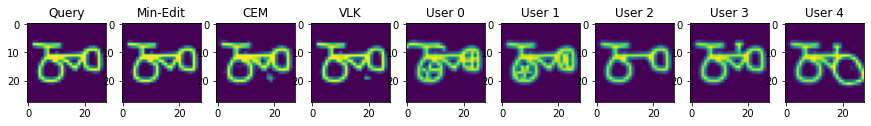

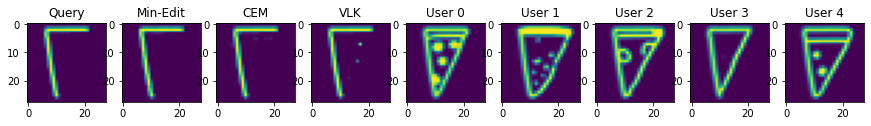

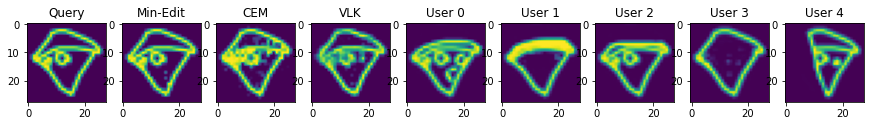

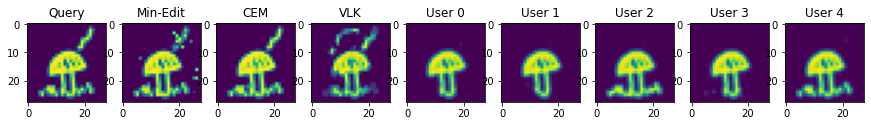

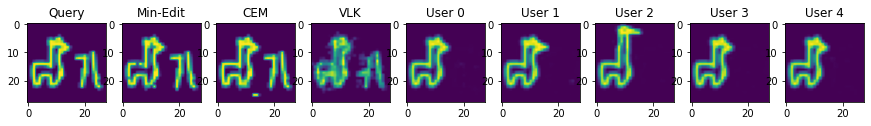

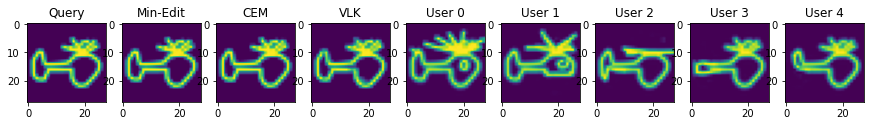

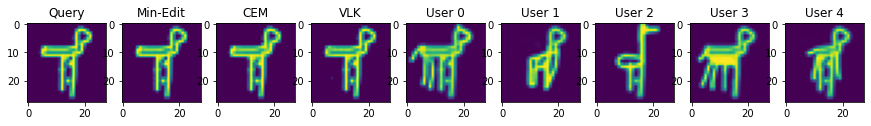

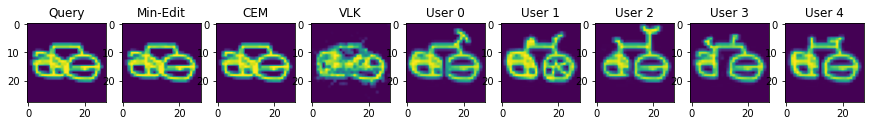

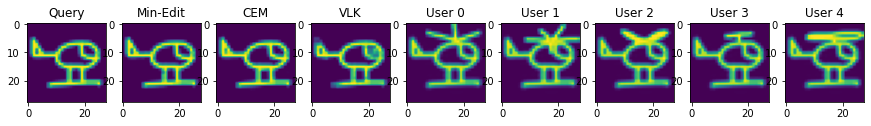

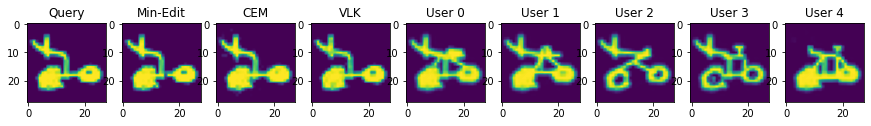

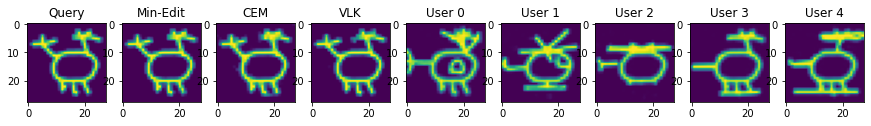

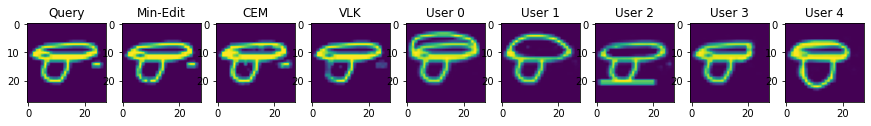

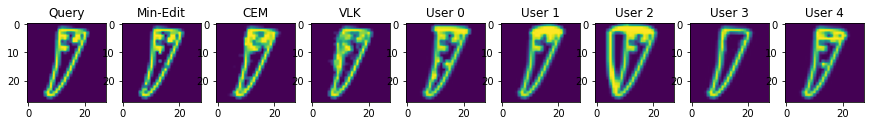

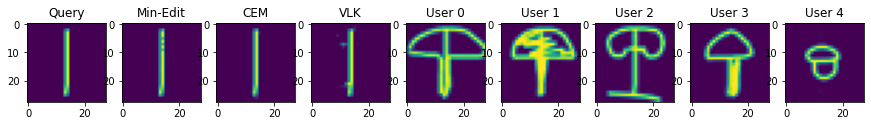

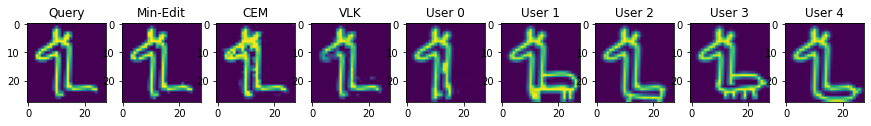

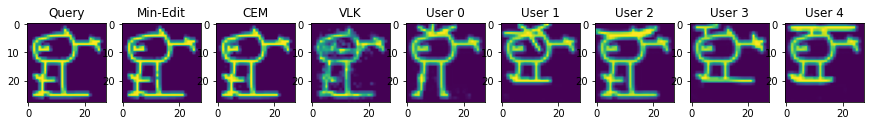

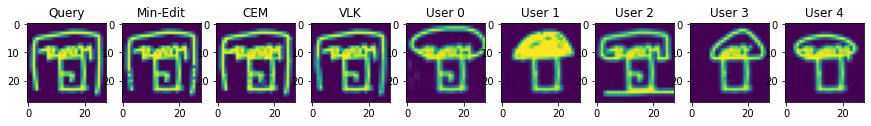

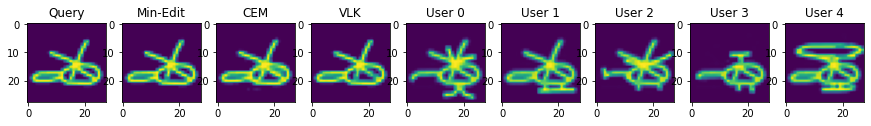

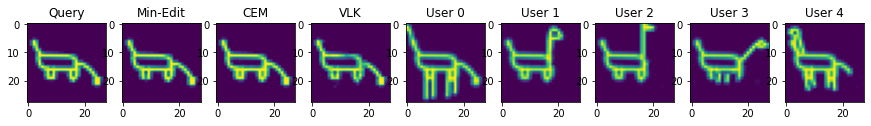

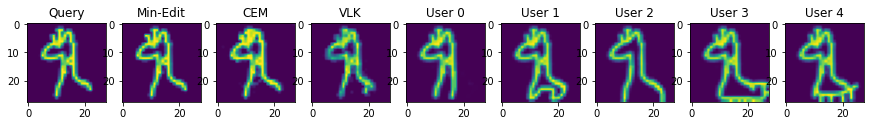

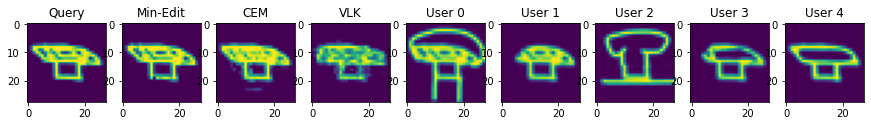

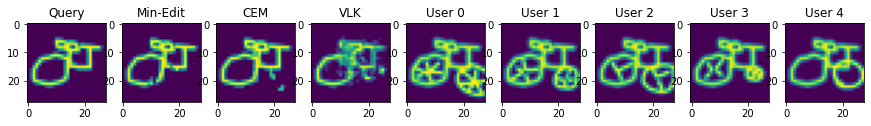

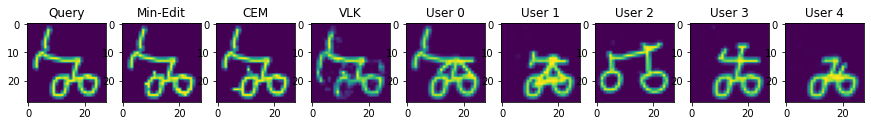

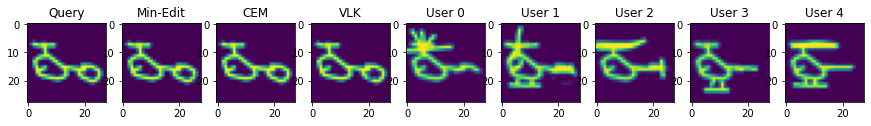

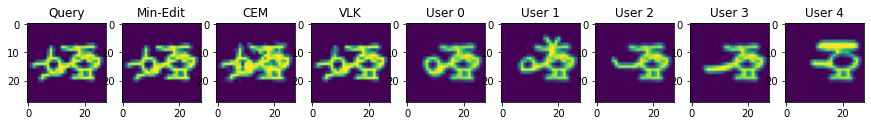

In [121]:
for image in range(30):

    image_index = image

    f, axarr = plt.subplots(nrows=1,ncols=9, figsize=(15,15))
    plt.sca(axarr[0]); 
    plt.imshow(x_test[misclassification_indices_test_set[image_index]], cmap='viridis'); plt.title('Query')

    
    plt.sca(axarr[1]); 
    plt.imshow(quickdraw_min_edit_cf[image_index],cmap='viridis'); plt.title('Min-Edit')

    plt.sca(axarr[2]); 
    plt.imshow(quickdraw_cem_cf[image_index],cmap='viridis'); plt.title('CEM')
    
    plt.sca(axarr[3]); 
    plt.imshow(quickdraw_vlk_cf[image_index],cmap='viridis'); plt.title('VLK')
    
    plt.sca(axarr[4]); 
    plt.imshow(user_0[image_index], cmap='viridis'); plt.title('User 0')

    plt.sca(axarr[5]); 
    plt.imshow(user_1[image_index], cmap='viridis'); plt.title('User 1');

    plt.sca(axarr[6]); 
    plt.imshow(user_2[image_index], cmap='viridis'); plt.title('User 2'); 


    plt.sca(axarr[7]); 
    plt.imshow(user_3[image_index], cmap='viridis'); plt.title('User 3');

    plt.sca(axarr[8]); 
    plt.imshow(user_4[image_index], cmap='viridis'); plt.title('User 4');


    plt.show()

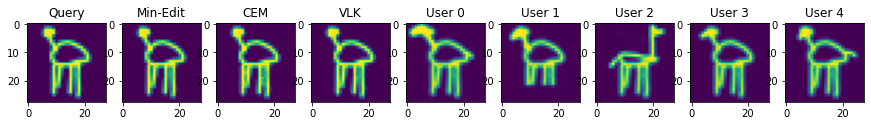

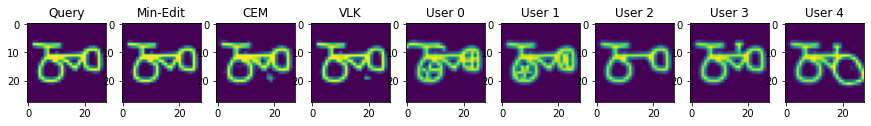

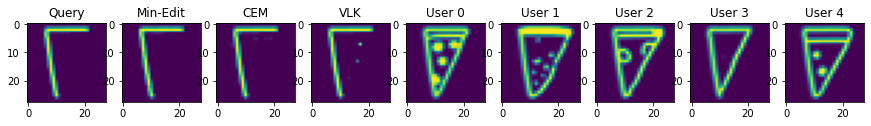

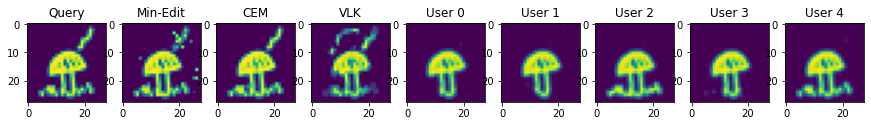

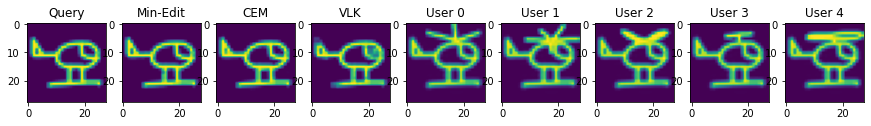

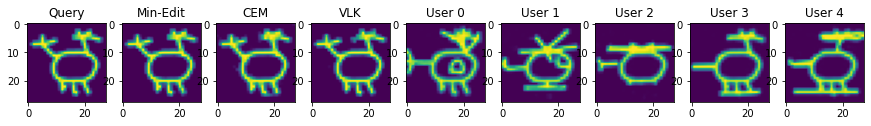

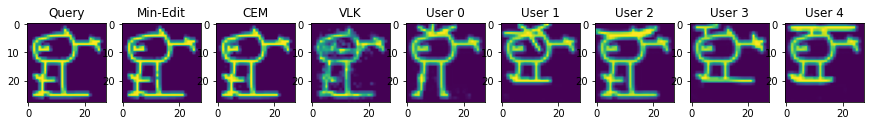

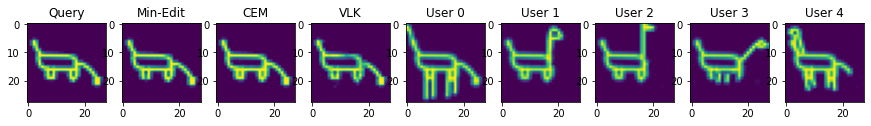

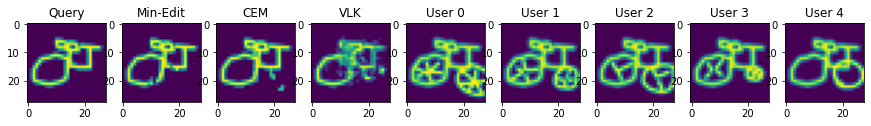

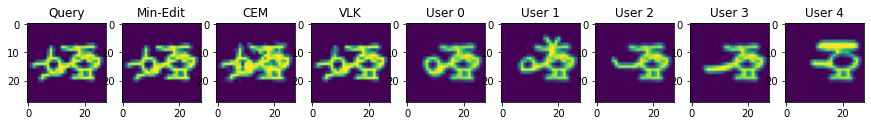

In [186]:
for image in [4,5,6,8,13,15,20,23,26,29]:

    image_index = image

    f, axarr = plt.subplots(nrows=1,ncols=9, figsize=(15,15))
    plt.sca(axarr[0]); 
    plt.imshow(x_test[misclassification_indices_test_set[image_index]], cmap='viridis'); plt.title('Query')

    
    plt.sca(axarr[1]); 
    plt.imshow(quickdraw_min_edit_cf[image_index],cmap='viridis'); plt.title('Min-Edit')

    plt.sca(axarr[2]); 
    plt.imshow(quickdraw_cem_cf[image_index],cmap='viridis'); plt.title('CEM')
    
    plt.sca(axarr[3]); 
    plt.imshow(quickdraw_vlk_cf[image_index],cmap='viridis'); plt.title('VLK')
    
    plt.sca(axarr[4]); 
    plt.imshow(user_0[image_index], cmap='viridis'); plt.title('User 0')

    plt.sca(axarr[5]); 
    plt.imshow(user_1[image_index], cmap='viridis'); plt.title('User 1');

    plt.sca(axarr[6]); 
    plt.imshow(user_2[image_index], cmap='viridis'); plt.title('User 2'); 


    plt.sca(axarr[7]); 
    plt.imshow(user_3[image_index], cmap='viridis'); plt.title('User 3');

    plt.sca(axarr[8]); 
    plt.imshow(user_4[image_index], cmap='viridis'); plt.title('User 4');


    plt.show()

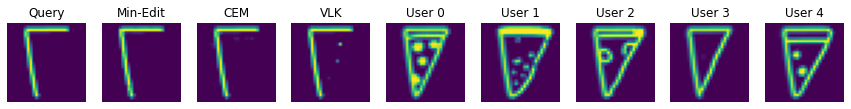

In [184]:
for image in [6]:

    image_index = image

    f, axarr = plt.subplots(nrows=1,ncols=9, figsize=(15,15))
    plt.sca(axarr[0]); 
    plt.imshow(x_test[misclassification_indices_test_set[image_index]], cmap='viridis'); plt.title('Query')
    plt.axis('off')

    
    plt.sca(axarr[1]); 
    plt.imshow(quickdraw_min_edit_cf[image_index],cmap='viridis'); plt.title('Min-Edit')
    plt.axis('off')

    plt.sca(axarr[2]); 
    plt.imshow(quickdraw_cem_cf[image_index],cmap='viridis'); plt.title('CEM')
    plt.axis('off')
    
    plt.sca(axarr[3]); 
    plt.imshow(quickdraw_vlk_cf[image_index],cmap='viridis'); plt.title('VLK')
    plt.axis('off')
    
    plt.sca(axarr[4]); 
    plt.imshow(user_0[image_index], cmap='viridis'); plt.title('User 0')
    plt.axis('off')

    plt.sca(axarr[5]); 
    plt.imshow(user_1[image_index], cmap='viridis'); plt.title('User 1');
    plt.axis('off')

    plt.sca(axarr[6]); 
    plt.imshow(user_2[image_index], cmap='viridis'); plt.title('User 2');
    plt.axis('off')


    plt.sca(axarr[7]); 
    plt.imshow(user_3[image_index], cmap='viridis'); plt.title('User 3');
    plt.axis('off')

    plt.sca(axarr[8]); 
    plt.imshow(user_4[image_index], cmap='viridis'); plt.title('User 4');
    plt.axis('off')


    plt.show()

### Comparisons - Proximity 

#### Distance between Query and CFE

In [134]:
import scipy

In [137]:
min_edit_l1 = []
cem_l1 = []
vlk_l1 = []

min_edit_l2 = []
cem_l2 = []
vlk_l2 = []

for image in range(30):
    
    query = x_test[misclassification_indices_test_set[image]].flatten()
    min_edit = quickdraw_min_edit_cf[image].flatten()
    cem = quickdraw_cem_cf[image].flatten()
    vlk = quickdraw_vlk_cf[image].flatten()
    
    min_edit_l1.append(scipy.spatial.distance.cityblock(query,min_edit))
    cem_l1.append(scipy.spatial.distance.cityblock(query,cem))
    vlk_l1.append(scipy.spatial.distance.cityblock(query,vlk))
    
    min_edit_l2.append(scipy.spatial.distance.euclidean(query,min_edit))
    cem_l2.append(scipy.spatial.distance.euclidean(query,cem))
    vlk_l2.append(scipy.spatial.distance.euclidean(query,vlk))
        

In [138]:
min_edit_l1 = np.array(min_edit_l1)
cem_l1 = np.array(cem_l1)
vlk_l1 = np.array(vlk_l1)

min_edit_l2 = np.array(min_edit_l2)
cem_l2 = np.array(cem_l2)
vlk_l2 = np.array(vlk_l2)

#### Human CFE Mean (We have several counterfactuals --- One for each user)

In [173]:
mean_l1 = []
mean_l2 = []

for instance in range(30):
    
    l1=[]
    
    l2 = []
    
    for user in [user_0, user_1, user_2, user_3, user_4]:
        l1.append(scipy.spatial.distance.cityblock(x_test[misclassification_indices_test_set[instance]].flatten(), user[instance].flatten()))
        l2.append(scipy.spatial.distance.euclidean(x_test[misclassification_indices_test_set[instance]].flatten(), user[instance].flatten()))
    mean_l1.append(np.mean(np.mean(l1)))
    mean_l2.append(np.mean(np.mean(l2)))

In [179]:
import scikit_posthocs as sp
from scipy.stats import stats

##### Manhattan

In [180]:
fvalue, pvalue = stats.f_oneway(np.array(min_edit_l1), np.array(cem_l1), np.array(vlk_l1),
                                np.array(mean_l1))
print(fvalue, pvalue)

107.02965388851811 2.8630247707542682e-33


In [182]:
sp.posthoc_conover([np.array(min_edit_l1), np.array(cem_l1), np.array(vlk_l1), np.array(mean_l1)], p_adjust='holm')

,1,2,3,4
1,1.000000e+00,6.654550e-04,7.842139e-06,9.643370e-24
2,6.654550e-04,1.000000e+00,2.157787e-01,3.790384e-15
3,7.842139e-06,2.157787e-01,1.000000e+00,2.307907e-12
4,9.643370e-24,3.790384e-15,2.307907e-12,1.000000e+00


##### Euclidean 

In [181]:
fvalue, pvalue = stats.f_oneway(np.array(min_edit_l2), np.array(cem_l2), np.array(vlk_l2),
                                np.array(mean_l2))
print(fvalue, pvalue)

123.61999108098533 5.5993533712269357e-36


In [183]:
sp.posthoc_conover([np.array(min_edit_l2), np.array(cem_l2), np.array(vlk_l2), np.array(mean_l2)], p_adjust='holm')

,1,2,3,4
1,1.000000e+00,2.669517e-05,1.332087e-07,4.888399e-27
2,2.669517e-05,1.000000e+00,1.926515e-01,1.521596e-16
3,1.332087e-07,1.926515e-01,1.000000e+00,1.407108e-13
4,4.888399e-27,1.521596e-16,1.407108e-13,1.000000e+00


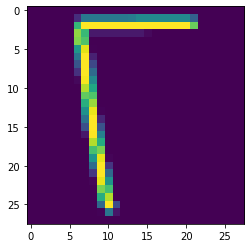

In [198]:
plt.imshow(x_test[misclassification_indices_test_set[6]])

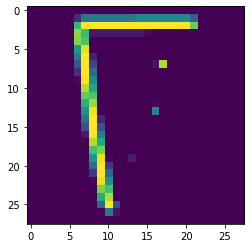

In [204]:
plt.imshow(quickdraw_vlk_cf[6])

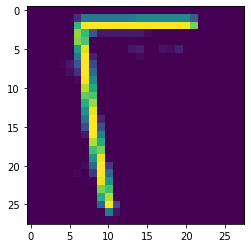

In [205]:
plt.imshow(quickdraw_cem_cf[6])

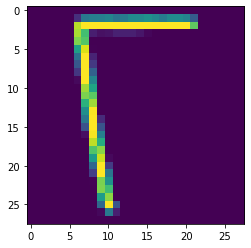

In [206]:
plt.imshow(quickdraw_min_edit_cf[6])